In [136]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import PromptTemplate
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from IPython.display import Image
load_dotenv()

True

In [ ]:
llm = ChatOpenAI (model='gpt-4o-mini')
str_parser = StrOutputParser()

In [ ]:
# parser
class Score(BaseModel):
    score: float = Field(description="score",)


parser = PydanticOutputParser(pydantic_object=Score)

In [139]:
# prompt

prompt_for_cot = PromptTemplate(
    input_variables=["essay_text"],
    template=(
        "Evaluate the following essay for *Clarity of Thought*: "
        "Are the ideas expressed in a clear, logical, and understandable way? "
        "Return only a percentage score (0–100).\n\nEssay:\n{essay_text} \n {format_instruction}"
    ),
    partial_variables={"format_instruction": parser.get_format_instructions()},
)

prompt_for_doa = PromptTemplate(
    input_variables=["essay_text"],
    template=(
        "Evaluate the following essay for *Depth of Analysis*: "
        "Does the essay provide deep insights, reasoning, and well-supported arguments? "
        "Return only a percentage score (0–100).\n\nEssay:\n{essay_text} \n {format_instruction}"
    ),
    partial_variables={"format_instruction": parser.get_format_instructions()},
)

prompt_for_language = PromptTemplate(
    input_variables=["essay_text"],
    template=(
        "Evaluate the following essay for *Language*: "
        "Consider grammar, vocabulary, sentence structure, and fluency. "
        "Return only a percentage score (0–100).\n\nEssay:\n{essay_text}\n {format_instruction}"
    ),
    partial_variables={"format_instruction": parser.get_format_instructions()},
)

prompt_for_final_feedback = PromptTemplate(
    input_variables=[
        "clarity_of_thought_score",
        "depth_of_analysis_score",
        "language_feedback_score",
        "essay_text",
    ],
    template=(
        "You are evaluating an essay based on three criteria:\n"
        "- Clarity of Thought: {clarity_of_thought_score}%\n"
        "- Depth of Analysis: {depth_of_analysis_score}%\n"
        "- Language: {language_feedback_score}%\n\n"
        "Essay:\n{essay_text}\n\n"
        "1. Provide a brief overall evaluation (2–3 sentences) that summarizes the essay’s strengths and weaknesses.\n"
        "2. Give a **Final Feedback Score (0–100)** that reflects the average of the three scores but also considers overall impression."
    ),
)

In [140]:
# define state
class state(TypedDict):
    essay_text: str
    clarity_of_thought_score: float
    depth_of_analysis_score: float
    language_feedback_score: float

    final_feedback: str
    # individual_score: list
    # final_score: float

In [141]:
def clarity_of_thought_score(state: state) -> state:

    chain1 = prompt_for_cot | llm | parser

    cot = chain1.invoke({"essay_text": state["essay_text"]})

    state["clarity_of_thought_score"] = cot.score

    return {"clarity_of_thought_score": cot.score}

In [142]:
def depth_of_analysis_score(state: state) -> state:

    chain2 = prompt_for_doa | llm | parser

    doa = chain2.invoke({"essay_text": state["essay_text"]})

    state["depth_of_analysis_score"] = doa.score

    return {"depth_of_analysis_score": doa.score}

In [143]:
def language_feedback_score(state: state) -> state:

    chain3 = prompt_for_language | llm | parser

    language = chain3.invoke({"essay_text": state["essay_text"]})

    state["language_feedback_score"] = language.score

    return {"language_feedback_score": language.score}

In [144]:
def final_feedback(state: state) -> state:
    chain4 = prompt_for_final_feedback | llm | str_parser

    final_feedback = chain4.invoke(
        {
            "clarity_of_thought_score": state["clarity_of_thought_score"],
            "depth_of_analysis_score": state["depth_of_analysis_score"],
            "language_feedback_score": state["language_feedback_score"],
            "essay_text": state["essay_text"],
        }
    )
    state["final_feedback"] = final_feedback

    return {"final_feedback": final_feedback}

In [145]:
# Define the graph
graph = StateGraph(state)

In [146]:
# add nodes
graph.add_node("clarity_of_thought_score", clarity_of_thought_score)
graph.add_node("depth_of_analysis_score", depth_of_analysis_score)
graph.add_node("language_feedback_score", language_feedback_score)
graph.add_node("final_feedback", final_feedback)

In [147]:
# add edges
graph.add_edge(START, "clarity_of_thought_score")
graph.add_edge(START, "depth_of_analysis_score")
graph.add_edge(START, "language_feedback_score")

#
graph.add_edge("clarity_of_thought_score", "final_feedback")
graph.add_edge("depth_of_analysis_score", "final_feedback")
graph.add_edge("language_feedback_score", "final_feedback")
#
graph.add_edge("final_feedback", END)

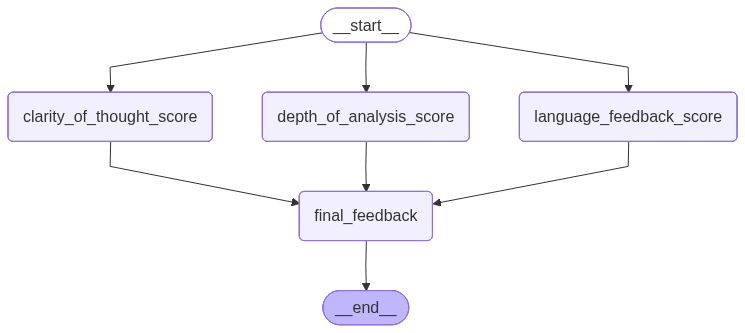

In [148]:
# compile the graph
work_flow = graph.compile()
# View Graph
Image(work_flow.get_graph().draw_mermaid_png())

In [149]:
# execute the graph

initial_state = {
    "essay_text": """Anie is my favorite thing to watch after school. I like it because the characters look cool and he stories are exciting. My first anime was Naruto, and I liked how he nevr gave up even when things were hard. Now I also watch Demon Slayer, which has amazing fights and really nice animation. Sometimes I tr to draw the characters in my notebook, bu they never look as good as in the show. Anime also teaches me lessons, like teamwork, friendship, and working hard for your dreams. I want to visi Japan one day to see where anime is made. For me, anime is not just cartoons, it is a big part of my life.
        """
}

final_state = work_flow.invoke(initial_state)

In [150]:
# print state
print(final_state)

{'essay_text': 'Anie is my favorite thing to watch after school. I like it because the characters look cool and he stories are exciting. My first anime was Naruto, and I liked how he nevr gave up even when things were hard. Now I also watch Demon Slayer, which has amazing fights and really nice animation. Sometimes I tr to draw the characters in my notebook, bu they never look as good as in the show. Anime also teaches me lessons, like teamwork, friendship, and working hard for your dreams. I want to visi Japan one day to see where anime is made. For me, anime is not just cartoons, it is a big part of my life.\n        ', 'clarity_of_thought_score': 75.0, 'depth_of_analysis_score': 50.0, 'language_feedback_score': 75.0, 'final_feedback': 'Overall, the essay presents a clear enthusiasm for anime, showcasing a personal connection and some insightful reflections on its themes. However, it suffers from a lack of depth in analysis and several language errors that detract from the overall cl